# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

Using TensorFlow backend.


In [4]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images))
    f.set_figwidth(15)
    for ax,image,caption in zip(axes, images, captions):
        ax.imshow(image, cmap)
        ax.set_title(caption)

In [13]:
# define the path where training and validation data are placed.
SOURCE_PATH = os.getcwd()

# Training data constants
TRAIN_DATA_PATH = SOURCE_PATH + '/Project_data/train'
TRAIN_DATA_CSV = SOURCE_PATH + '/Project_data/train.csv'

# Validation data constants
VALIDATION_DATA_PATH = SOURCE_PATH + '/Project_data/val'
VALIDATION_DATA_CSV = SOURCE_PATH + '/Project_data/val.csv'

BATCH_SIZE = 12;

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open(TRAIN_DATA_CSV).readlines())
val_doc = np.random.permutation(open(VALIDATION_DATA_CSV).readlines())

print("Training data size = {}".format(len(train_doc)))
print("Validation data size = {}".format(len(val_doc)))

Training data size = 663
Validation data size = 100


---
### Choosing Frame Dimenstion:

- Lets visualize 360x360 and 120x160 image in different dimension as below:
    - 360x360
    - 240x240
    - 120x160

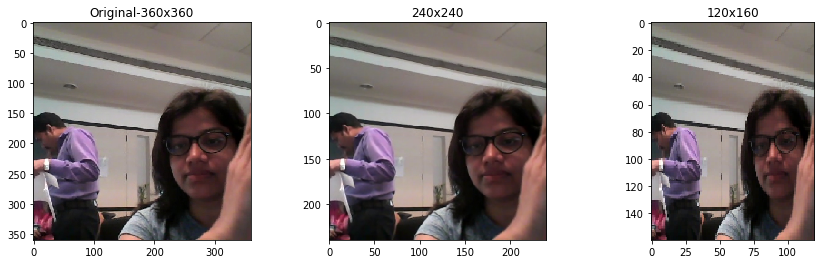

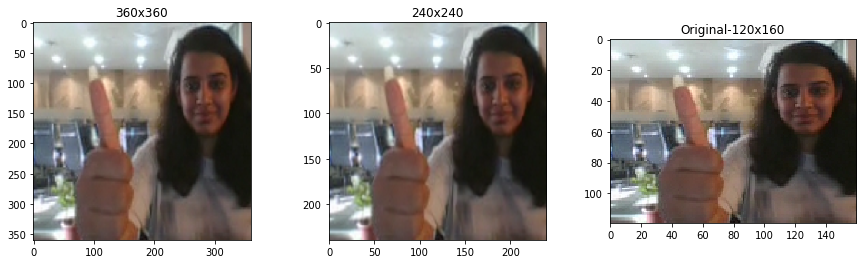

In [12]:
# below is 360x360 image frame
largeSizeImage = cv2.cvtColor(
    cv2.imread(
        TRAIN_DATA_PATH + '/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png'),
    cv2.COLOR_BGR2RGB)
# below is 120x160 image frame
smallSizeImage = cv2.cvtColor(
    cv2.imread(
        TRAIN_DATA_PATH + '/WIN_20180925_17_22_11_Pro_Thumbs_Up_new/WIN_20180925_17_22_11_Pro_00041.png'),
    cv2.COLOR_BGR2RGB)

# resize of 360x360 image and plot
largeSizeImageResizeTo120 = cv2.resize(largeSizeImage, (120, 160))
largeSizeImageResizeTo240 = cv2.resize(largeSizeImage, (240, 240))
plot_image([largeSizeImage, largeSizeImageResizeTo240, largeSizeImageResizeTo120], captions = ["Original-360x360", "240x240", "120x160" ])

# resize of 120x160 image and plot
smallSizeImageResizeTo320 = cv2.resize(smallSizeImage, (360, 360))
smallSizeImageResizeTo240 = cv2.resize(smallSizeImage, (240, 240))
plot_image([smallSizeImageResizeTo320, smallSizeImageResizeTo240, smallSizeImage ], captions = ["360x360", "240x240" , "Original-120x160"])

- 240x240 dimension image seems to be good options in terms of picture clarity. Hence we would be resizing all the images to this.

In [ ]:
FRAME_RESIZE_DIMENSION = (240, 240)

---

### Possible Augmentations:
`Flipping`: `No`
- Up-down flip of frame will not be helpful
- Left-Right flip incase of fast forward or backward will consfuse the model


`Rotation` : `No`
- Rotating to certain angle is quite possible, but we would prefer no to use as data would already have certain degree of rotation.

`Cropping` : `No`
- Certain User actions like fast forward and backward, certain frames are around the edges. Hence good to avoid.

`Scaling` : `Yes`
- We are using this for resizing the image to common dimenstion(240x240) and can be feeded to model.

`Translation` : `No`
- With given problem statement, translating the frames may break the sequence of action which model actually needs to learn. 

In [34]:
class FrameProcessing():
    
    def __init__(self, path):
        """
            When the image file is read with the OpenCV function imread(), the order of colors is BGR.
            Hence changing it to RGB
        """
        self.image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    def get(self):
        """get the image array"""
        return self.image
    
    def resize(self):
        """ resize the image to 240x240 """
        self.image = cv2.resize(self.image, FRAME_RESIZE_DIMENSION, interpolation=cv2.INTER_AREA)
        return self
    
    def normalization(self):
        """normalize the image by dividing by 255"""
        self.image = self.image/255
        return self
        

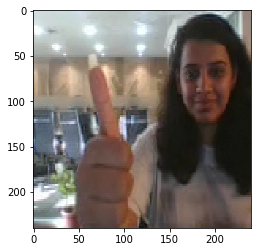

In [20]:
# Lets visualize an image
img = FrameProcessing(
    TRAIN_DATA_PATH + '/WIN_20180925_17_22_11_Pro_Thumbs_Up_new/WIN_20180925_17_22_11_Pro_00041.png').resize()
plt.imshow(img.get())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [33]:
def generator(source_path, folder_list, batch_size, imageskip=1):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30, imageskip))
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,x,y,z,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):                    
                    imageObj = FrameProcessing(
                        source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])

                    # just performing resize as discussed above
                    imageObj.resize()
                    imageObj.normalization()
                    
                    batch_data[folder,idx,:,:,0] = imageObj.get()[:,:,0]
                    batch_data[folder,idx,:,:,1] = imageObj.get()[:,:,1]
                    batch_data[folder,idx,:,:,2] = imageObj.get()[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

        
        # remaining data points which are left after full batches
        remaining_folder = len(t)%batch_size
        if (remaining_folder > 0):
            batch_data = np.zeros((remaining_folder,x,y,z,3))
            batch_labels = np.zeros((remaining_folder,5))
            for folders in range(remaining_folder):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    imageObj = FrameProcessing(
                        source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    # just performing resize as discussed above
                    imageObj.resize()
                    imageObj.normalization()
                    
                    batch_data[folder,idx,:,:,0] = imageObj.get()[:,:,0]
                    batch_data[folder,idx,:,:,1] = imageObj.get()[:,:,1]
                    batch_data[folder,idx,:,:,2] = imageObj.get()[:,:,2]
                
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels




Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/notebooks/storage/Final_data/Collated_training/train'
val_path = '/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = # choose the number of epochs
print ('# epochs =', num_epochs)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)